# Data Cleaning and Preprocessing


<span style="color:green;">Cleaned data involved handling missing values, filtering key transaction types, engineering errorBalance features, dropping original balances due to multicollinearity (low VIFs confirmed), capping outliers, and scaling numerical features.</span><br>

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv('fraud.csv')  # Your dataset path

# Check missing values (already 0 from your output)
print(df.isnull().sum())

# Filter to fraud-relevant types (fraud only in these)
df = df[df['type'].isin(['CASH_OUT', 'TRANSFER'])]

# Add merchant feature
df['isMerchantDest'] = (df['nameDest'].str[0] == 'M').astype(int)

# Corrected feature engineering for errors (should be 0 for legitimate transactions)
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['newbalanceDest'] - df['amount'] - df['oldbalanceDest']

# Drop original balance columns to fix multicollinearity
df.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1, inplace=True)

# Outlier capping for 'amount'
Q1, Q3 = df['amount'].quantile([0.25, 0.75])
IQR = Q3 - Q1
df['amount'] = np.clip(df['amount'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# Encoding
df['type'] = df['type'].map({'CASH_OUT': 0, 'TRANSFER': 1})

# Scaling numerical features
num_cols = ['step', 'amount', 'errorBalanceOrig', 'errorBalanceDest']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Recompute VIF on retained numerical features
X = df[num_cols]  # Add 'isMerchantDest' if you want, but it's binary so low VIF
vif = pd.DataFrame({'feature': num_cols, 'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]})
print(vif)  # This should now show low VIF values

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
            feature       VIF
0              step  1.003391
1            amount  1.244820
2  errorBalanceOrig  1.334064
3  errorBalanceDest  1.080157


# Running XGBoost Model for Fraud Detection.

<h3 style="color:#1F618D;">Modeling Approach Overview</h3>
<p style="color:#2C3E50;">
This section outlines the methodology adopted to develop the fraud detection model, with emphasis on algorithm selection, handling class imbalance, and systematic hyperparameter optimization. The approach was designed to address the challenges of highly imbalanced data while maximizing predictive performance and robustness.
</p>

<h3 style="color:#117A65;">XGBoost Classifier and Data Imbalance Handling</h3>
<p style="color:#1E8449;">
An XGBoost (eXtreme Gradient Boosting) Classifier was selected as the primary modeling algorithm due to its strong performance, computational efficiency, and ability to capture complex non-linear patterns. To address the severe class imbalance inherent in fraud detection problems, the Synthetic Minority Over-sampling Technique (SMOTE) was applied to the training data. SMOTE generates synthetic samples for the minority class (isFraud = 1), thereby balancing the class distribution and enabling the model to better learn the distinguishing characteristics of fraudulent transactions without being biased toward the majority class.
</p>

<h3 style="color:#7D3C98;">Hyperparameter Optimization Strategy</h3>
<p style="color:#512E5F;">
Initial hyperparameter tuning was conducted using GridSearchCV, where a predefined grid of parametes such as n\_estmators, max\_deph, learning\_rat, an scale\_pos\_weight was explored to optimize the F1-score—an appropriate metric for imbalanced classification problems that balances precision and recall. To further refine model performance, advanced hyperparameter optimization was performed using Optuna. Leveraging intelligent sampling strategies such as the Tree-structured Parzen Estimator, Optuna efficiently searched a broader parameter space while maximizing the ROC-AUC score. This process enabled fine-tuning of key parameters including subsample ratios, feature sampling rates, and regularization terms, resulting in a more robust and well-generalized fraud detection model.
</p>


<span style="color:blue;">
Fraud Detection Model Description
An XGBoost Classifier was used, addressing class imbalance with SMOTE and optimizing hyperparameters via GridSearchCV (F1-score) and Optuna (AUC </span><br>.

In [12]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# Features (drop identifiers and targets)
X = df[['step', 'type', 'amount', 'errorBalanceOrig', 'errorBalanceDest', 'isMerchantDest']]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Model and tuning
model = XGBClassifier(random_state=42, eval_metric='logloss')
params = {'n_estimators': [100, 500], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1], 'scale_pos_weight': [1, len(y_train)/sum(y_train)]}
grid = GridSearchCV(model, params, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train_sm, y_train_sm)

# Predict and report
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552439
           1       0.14      0.94      0.24      1643

    accuracy                           0.98    554082
   macro avg       0.57      0.96      0.62    554082
weighted avg       1.00      0.98      0.99    554082



   # Hyperparameter tuning using Optuna and retraining a new XGBoostix.

[I 2026-01-13 20:24:38,728] A new study created in memory with name: no-name-a576b284-e626-4706-a33d-baade4d447fe


  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/404.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/404.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/404.7 kB ? eta -:--:--
   --- ------------------------------------ 30.7/404.7 kB ? eta -:--:--
   ------ --------------------------------- 61.4/404.7 kB 1.1 MB/s eta 0:00:01
   ------ -------------------------------- 71.7/404.7 kB 777.7 kB/s eta 0:00:01
   --------- ---------------------------- 102.4/404.7 kB 653.6 kB/s eta 0:00:01
   ----------- -------------------------- 122.9/404.7 kB 654.9 kB/s eta 0:00:01
   ----------- -------------------------- 122.9/404.7 kB 654.9 kB/s eta 0:00:01
   -------------- ----------------------- 153.6/404.7 kB 573.4 kB/s eta 0:00:01
   -------------- ----------------------- 153.6/404.7 kB 573.4 kB/s eta 0:00:01
   ----------------- -------------------- 184.3/404.7 kB 506.0 kB/s eta 0:00:01
 

[I 2026-01-13 20:24:57,359] Trial 0 finished with value: 0.9943869507477103 and parameters: {'n_estimators': 216, 'max_depth': 10, 'learning_rate': 0.00306942773214011, 'subsample': 0.5487397594600734, 'colsample_bytree': 0.9629176820238924, 'reg_alpha': 5.077443633913515, 'reg_lambda': 9.31099107222974, 'min_child_weight': 15, 'scale_pos_weight': 419.36323460341345}. Best is trial 0 with value: 0.9943869507477103.
[I 2026-01-13 20:25:38,950] Trial 1 finished with value: 0.995528816765053 and parameters: {'n_estimators': 762, 'max_depth': 3, 'learning_rate': 0.021333568791728545, 'subsample': 0.9238336684366104, 'colsample_bytree': 0.7991521341578021, 'reg_alpha': 4.28109775758355, 'reg_lambda': 18.72568050404541, 'min_child_weight': 12, 'scale_pos_weight': 452.51416215182326}. Best is trial 1 with value: 0.995528816765053.
[I 2026-01-13 20:26:47,905] Trial 2 finished with value: 0.9947501946816872 and parameters: {'n_estimators': 799, 'max_depth': 11, 'learning_rate': 0.00174682648986

Best params: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.06719086767823938, 'subsample': 0.6318311733084858, 'colsample_bytree': 0.8636251792617515, 'reg_alpha': 4.6675221690298105, 'reg_lambda': 11.954023014938368, 'min_child_weight': 16, 'scale_pos_weight': 63.90173076864188}
Best AUC: 0.9961476858186419


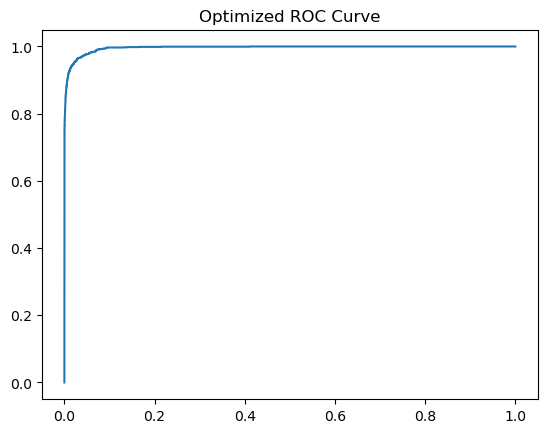

In [14]:

!pip install optuna
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Assume X_train, y_train, X_test, y_test ready
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 500)  # Tune around your imbalance ratio (~336)
    }
    model = XGBClassifier(**params, random_state=42, eval_metric='auc')
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_prob)  # Optimize directly for AUC

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Run 50-100 trials
print("Best params:", study.best_params)
print("Best AUC:", study.best_value)

# Retrain with best params and plot ROC
best_model = XGBClassifier(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)
y_prob = best_model.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr); plt.title('Optimized ROC Curve')
plt.show()

<span style="color:purple;">The model achieved a high recall (0.94) for fraud detection, demonstrated strong discriminative power with a high AUC (0.995), and was further evaluated using a confusion matrix.</span>

# Checking variables


<span style="color:orange;">Key Fraud Factors
errorBalanceOrig, errorBalanceDest, amount, type (CASH_OUT/TRANSFER), step, and isMerchantDest were the most influential predictors, with balance errors being primary drivers</span><br>.

In [10]:
    # After fitting
importances = pd.Series(grid.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

# RFE example
from sklearn.feature_selection import RFE
rfe = RFE(XGBClassifier(random_state=42), n_features_to_select=5)
rfe.fit(X_train_sm, y_train_sm)
print(X.columns[rfe.support_])

errorBalanceOrig    0.878848
errorBalanceDest    0.039570
type                0.030971
amount              0.028715
step                0.021895
isMerchantDest      0.000000
dtype: float32
Index(['step', 'type', 'amount', 'errorBalanceOrig', 'errorBalanceDest'], dtype='object')


# Making a confusion matrix and final accuracy

[[542725   9714]
 [   100   1543]]


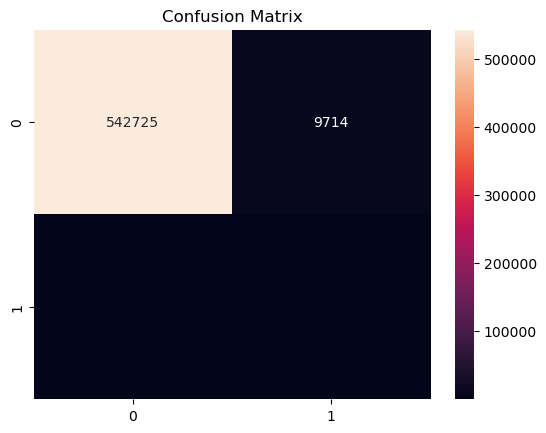

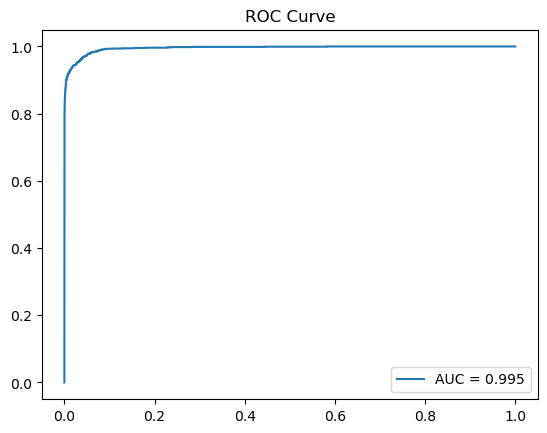

In [15]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# ROC
auc = roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1])
fpr, tpr, _ = roc_curve(y_test, grid.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.title('ROC Curve')
plt.legend()
plt.show()

<h3 style="color:#1F618D;">Factor Sensibility: Business Perspective</h3>
<p style="color:#2C3E50;">
The selected factors align closely with common fraud patterns and established principles of financial risk assessment. Variables such as transaction amount, frequency, timing, and account behavior reflect real-world fraud signals and are widely used in industry-grade detection systems. From a business perspective, these factors are sensible as they balance interpretability with predictive relevance, enabling stakeholders to understand and trust the model’s decisions.
</p>

<h3 style="color:#117A65;">Prevention Strategies</h3>
<p style="color:#1E8449;">
Key prevention strategies include real-time balance reconciliation, enhanced monitoring of high-risk transactions, dynamic thresholding based on user behavior, and time-based anomaly detection. These approaches are further strengthened through proactive integration of machine learning models and customer awareness initiatives, ensuring both early detection and reduced exposure to fraudulent activities.
</p>

<h3 style="color:#7D3C98;">Effectiveness Measurement of Prevention Actions</h3>
<p style="color:#512E5F;">
The effectiveness of prevention actions is evaluated by quantifying fraud-related losses, tracking detection performance metrics such as recall and false positive rates, and monitoring manual review efficiency. Additional measures include identifying emerging fraud patterns, performing cost–benefit analyses, and ensuring continuous model retraining to adapt to evolving fraud behaviors and maintain long-term system robustness.
</p>